# Training UNet for drop segmentation

In [57]:
import torch
from checkpoints import *
from measures import *

In [65]:
config = {
    "lr": 0.001,
    "batch_size": 8,
    "epochs": 20,
    "threshold": 0.3,
    "init_from_checkpoint": False,
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "checkpoints",
    "checkpoint": "UNetAdamBCEt36v32e50.pt", # if None loads last saved checkpoint
    "print_model": False,
    "seed": 3409 # if None uses random seed
}
print(f"Training using {config['device']}")

Training using cuda


In [66]:
# Set seed
if config["seed"] is not None:
    torch.manual_seed(config["seed"])  

In [67]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 678 images

Train: 611 images, 77 batches
Val: 67 images, 9 batches


In [68]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet
from unet import init_weights
from pathlib import Path

model = UNet(3).to(config['device'])

# Load or fill weights
# And set the start_epoch of model
if config["init_from_checkpoint"]:
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.normal_, mean=0., std=1)
    print("Randomly initiated parameters")
    start_epoch = 0

# Set optimizer & loss_fn
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Randomly initiated parameters


In [69]:
def check_accuracy_and_save(model, optimizer, loss_fn, epoch, train_loss, save=True):
    model.eval()

    losses = []
    accuracies = []
    precisions = []
    recalls = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            
            pred = torch.sigmoid(model(x))
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            
            accuracies.append(accuracy(y, pred))
            precisions.append(precision(y, pred))
            recalls.append(recall(y, pred))
            
    mean = lambda l: sum(l) / len(l)
    mean_loss = mean(losses)
    print("Valid loss:", mean_loss, '\n')
    print("Accuracy: ", mean(accuracies))
    print("Precision:", mean(precisions))
    print("Recall:   ", mean(recalls), '\n')
    model.train()

    if save:
        save_checkpoint(
            config["checkpoint_dir"],
            model,
            optimizer,
            loss_fn,
            epoch,
            train_loss,
            mean_loss
        )

In [70]:
from tqdm.notebook import tqdm
from sys import stdout
def train(epochs=config['epochs'], save_checkpoints=True):
    for epoch in range(epochs):
        epoch += start_epoch
        print("Epoch", epoch)
        
        loader = tqdm(train_loader)
        losses = []
        
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss = loss.item()
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)

        mean_loss = sum(losses) / len(losses)
        print("Train loss:", mean_loss)
        check_accuracy_and_save(
            model, 
            optimizer,
            loss_fn,
            epoch, 
            mean_loss,
            save=save_checkpoints
        )

In [71]:
train(epochs = 30, save_checkpoints=False)

Epoch 0


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 4.935347117386855
Valid loss: 4.458908716837565 

Accuracy:  0.6225878685988762
Precision: 0.0025311110804253716
Recall:    0.4320434555012509 

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 1.9115385250611738


/beta/students/kondrashov/WaterDropDetection/research/segmentation/measures.py:16: RuntimeWarning: invalid value encountered in scalar divide
  acc = (y * z).sum() / y.sum()


Valid loss: 0.8596488436063131 

Accuracy:  0.7513110902574327
Precision: nan
Recall:    0.4230627698513369 

Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.8081484262819414
Valid loss: 0.7511742843521966 

Accuracy:  0.7692829915494831
Precision: 0.30022897116012043
Recall:    0.4141251540708321 

Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.6293585757156471
Valid loss: 0.6002160509427389 

Accuracy:  0.797909411015334
Precision: 0.3777918454811529
Recall:    0.39506139637281495 

Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5960734563988525
Valid loss: 0.5790426002608405 

Accuracy:  0.8006837224518811
Precision: nan
Recall:    0.40103712600345415 

Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5818977762352336
Valid loss: 0.5932146906852722 

Accuracy:  0.8008080638117261
Precision: nan
Recall:    0.40219473783616666 

Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5690317618382441
Valid loss: 0.5824962357680002 

Accuracy:  0.7997835910430662
Precision: 0.3661191459331248
Recall:    0.3941002750458817 

Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.568400219663397
Valid loss: 0.5862357285287645 

Accuracy:  0.7996257397311706
Precision: 0.37949112899325516
Recall:    0.4336981891343991 

Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5711376450278542
Valid loss: 0.5620610382821825 

Accuracy:  0.8087950804167323
Precision: 0.3883355008093295
Recall:    0.40971518043833954 

Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5540624291865857
Valid loss: 0.6094611452685462 

Accuracy:  0.7887512326792434
Precision: 0.3316124164395862
Recall:    0.42392260632995105 

Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5516110403197152
Valid loss: 0.565370692147149 

Accuracy:  0.8087145081824727
Precision: nan
Recall:    0.3967523969606393 

Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5436147184340985
Valid loss: 0.5477464066611396 

Accuracy:  0.8146560283170806
Precision: 0.445438897099208
Recall:    0.4594384946480945 

Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5362987638293922
Valid loss: 0.5480194124910567 

Accuracy:  0.8129802663569098
Precision: 0.34959821044294925
Recall:    0.4112084051594138 

Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5424767597155138
Valid loss: 0.5374386443032159 

Accuracy:  0.8204259036315812
Precision: 0.47270882081378385
Recall:    0.41136341873142457 

Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5345230733419394
Valid loss: 0.5488088064723544 

Accuracy:  0.8163278916919673
Precision: nan
Recall:    0.4461944487842697 

Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5351000749445581
Valid loss: 0.5548782116836972 

Accuracy:  0.8121981107526355
Precision: 0.38505516332332734
Recall:    0.4427533774050298 

Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5277872089441721
Valid loss: 0.5346160895294614 

Accuracy:  0.8201081134654857
Precision: nan
Recall:    0.4560956205758784 

Epoch 17


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5277714477731036
Valid loss: 0.5102903346220652 

Accuracy:  0.83287397744479
Precision: nan
Recall:    0.4137262075587555 

Epoch 18


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5253056458064488
Valid loss: 0.5239565008216434 

Accuracy:  0.8235236563616328
Precision: nan
Recall:    0.4447577427037888 

Epoch 19


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5201583609178468
Valid loss: 0.5314271052678426 

Accuracy:  0.8238497381960904
Precision: 0.3914782927475042
Recall:    0.4381792394927254 

Epoch 20


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5167100150863846
Valid loss: 0.5196695692009397 

Accuracy:  0.8253318841258684
Precision: 0.42053704639827766
Recall:    0.4537622297262984 

Epoch 21


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.50730330564759
Valid loss: 0.4997929765118493 

Accuracy:  0.8347037456653736
Precision: 0.46667320364051396
Recall:    0.4279160231558813 

Epoch 22


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.5014945884029587
Valid loss: 0.4997989171081119 

Accuracy:  0.8336881059739325
Precision: 0.43302765585206177
Recall:    0.4485312545396111 

Epoch 23


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4920466666097765
Valid loss: 0.5417970336145825 

Accuracy:  0.8192837820560844
Precision: nan
Recall:    0.4497177478753858 

Epoch 24


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.491922650631372
Valid loss: 0.5078980028629303 

Accuracy:  0.8306616580596677
Precision: 0.5272233137102039
Recall:    0.42696373847623664 

Epoch 25


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4901760607570797
Valid loss: 0.4737650652726491 

Accuracy:  0.8441624467571577
Precision: 0.43643666748647336
Recall:    0.4696834839328572 

Epoch 26


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4867003467175868
Valid loss: 0.4944500856929355 

Accuracy:  0.8370756846335199
Precision: nan
Recall:    0.4759084460566993 

Epoch 27


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4846592301672155
Valid loss: 0.48733489049805534 

Accuracy:  0.8398015951668775
Precision: nan
Recall:    0.4567046510055661 

Epoch 28


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.47504506676228014
Valid loss: 0.47110526429282296 

Accuracy:  0.8473553185661634
Precision: 0.5631605853085165
Recall:    0.457904099866196 

Epoch 29


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.47809739817272534
Valid loss: 0.46490462952189976 

Accuracy:  0.8471688978649952
Precision: 0.5218769084938146
Recall:    0.46420800095182607 



In [72]:
config["lr"] = 4e-4

In [73]:
train(epochs = 17, save_checkpoints=False)

Epoch 0


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.47517012311266615
Valid loss: 0.48750173052151996 

Accuracy:  0.8379691080362709
Precision: 0.4520605712853096
Recall:    0.48575246734199706 

Epoch 1


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.47066990469957326
Valid loss: 0.5054248935646481 

Accuracy:  0.8327493046720823
Precision: nan
Recall:    0.4436948466356154 

Epoch 2


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4816673363184
Valid loss: 0.47590841518508065 

Accuracy:  0.8439882955065481
Precision: 0.4719429760481472
Recall:    0.47980267537274846 

Epoch 3


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.45362461116406827
Valid loss: 0.46335210071669686 

Accuracy:  0.8484172890031779
Precision: nan
Recall:    0.45364262036013386 

Epoch 4


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4587919746900534
Valid loss: 0.4784479770395491 

Accuracy:  0.841676245133082
Precision: nan
Recall:    0.5094824021475183 

Epoch 5


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.45505054469232437
Valid loss: 0.4917619890636868 

Accuracy:  0.8358770553712492
Precision: 0.3767306664958596
Recall:    0.4965696929850512 

Epoch 6


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4492086276605532
Valid loss: 0.4714314507113563 

Accuracy:  0.8462938812595826
Precision: 0.5185167941230315
Recall:    0.506925608134932 

Epoch 7


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4450140502545741
Valid loss: 0.4298368725511763 

Accuracy:  0.8614814121414114
Precision: 0.5378425235825557
Recall:    0.46108373352466586 

Epoch 8


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4491571021544469
Valid loss: 0.49503518144289654 

Accuracy:  0.8363079481102802
Precision: 0.6516423733146103
Recall:    0.4754401688222532 

Epoch 9


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.43797225998593614
Valid loss: 0.4341283705499437 

Accuracy:  0.8592293508074902
Precision: 0.5438750811197139
Recall:    0.5034466206044372 

Epoch 10


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.43860511539818403
Valid loss: 0.4417836235629188 

Accuracy:  0.8569408042563332
Precision: 0.6032379426889949
Recall:    0.4860453059275945 

Epoch 11


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4261723903866557
Valid loss: 0.4578177465332879 

Accuracy:  0.8505073871325564
Precision: 0.623080818189515
Recall:    0.48886356250969354 

Epoch 12


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4304183462223449
Valid loss: 0.43715107440948486 

Accuracy:  0.856849643919203
Precision: 0.5173523724769001
Recall:    0.5256706298915325 

Epoch 13


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4223225759221362
Valid loss: 0.4494228992197249 

Accuracy:  0.8545150955518087
Precision: nan
Recall:    0.5114511617769798 

Epoch 14


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.42637950762525784
Valid loss: 0.4631083673901028 

Accuracy:  0.847764547776293
Precision: 0.6428601673493782
Recall:    0.49143280206179174 

Epoch 15


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.4259027196215345
Valid loss: 0.40412704149882 

Accuracy:  0.87096115808796
Precision: nan
Recall:    0.5321987185075328 

Epoch 16


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.42229138953345163
Valid loss: 0.4371768765979343 

Accuracy:  0.858441931505998
Precision: nan
Recall:    0.470549783496945 



In [74]:
train(epochs = 1, save_checkpoints=True)

Epoch 0


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.42488343142843865
Valid loss: 0.5241761869854398 

Accuracy:  0.8462025915031081
Precision: 0.46387222523076665
Recall:    0.5960479323510771 

Progress saved to 'checkpoints/UNetAdamBCEt42v52e0.pt'


# Estimation

In [53]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [94]:
def plot_prediction(dataset, idx, binary_map=True, binary_threshold=0.42):
    x, y = val_dataset[idx]
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    print("Accuracy: ", accuracy([y], [pred]))
    print("Precision:", precision([y], [pred]))
    print("Recall:   ", recall([y], [pred]))
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))

    # If x is hsv
    saturation = x[1]
    x = np.transpose(x, (1, 2, 0))
    print(x.shape)

    from matplotlib.colors import hsv_to_rgb
    x = hsv_to_rgb(x)
    axs[0].imshow(x)
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 57
Accuracy:  0.761260986328125
Precision: 0.8695682287216187
Recall:    0.7895444895213671
(256, 256, 3)


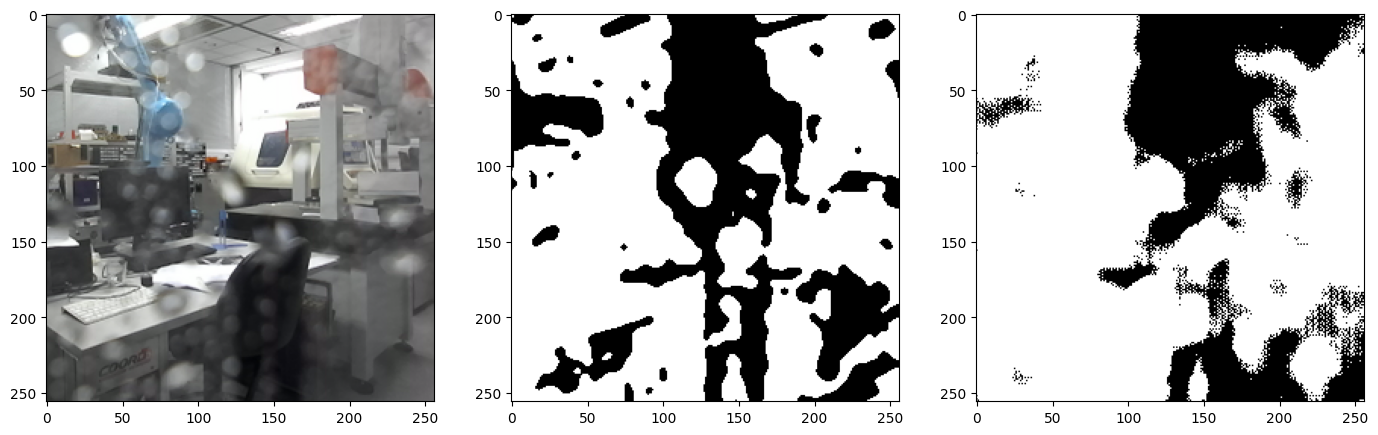

In [95]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
plot_prediction(val_dataset, idx, binary_map=True)

In [89]:
# Clear checkpoints by condition
#clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["val_loss"] >= 0.34, save_last=0)

In [96]:
!ls -la checkpoints

total 1455488
drwxrwsr-x 2 kondrashov students      4096 Aug  6 10:22 .
drwxrwsr-x 5 kondrashov students      4096 Aug  6 12:08 ..
-rw-rw-r-- 1 kondrashov students 372596781 Aug  5 23:17 UNetAdamBCEt36v32e50.pt
-rw-rw-r-- 1 kondrashov students 372596781 Aug  5 23:17 UNetAdamBCEt37v30e49.pt
-rw-rw-r-- 1 kondrashov students 372596781 Aug  5 23:21 UNetAdamBCEt37v31e50.pt
-rw-rw-r-- 1 kondrashov students 372596469 Aug  6 10:23 UNetAdamBCEt42v52e0.pt
